In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [37]:
pd.set_option('display.max_columns', None)

# 00. Loading data

In [77]:
PATH = '../data/'
MODEL_PATH = '../model/'

## Score data
This data is the one we will use as input to our prediction

In [39]:
score_historical = pd.read_csv(PATH + 'input/' + 'spreadspoke_scores.csv')
score_historical = score_historical[[
    'schedule_date',
    'schedule_season',
    'schedule_week',
    'schedule_playoff',
    'team_home',
    'score_home',
    'score_away',
    'team_away',
    'stadium_neutral'
]]
score_historical.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,stadium_neutral
0,9/2/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,False
1,9/3/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,False
2,9/4/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,False
3,9/9/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,False
4,9/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,False


Translate team name for pattern.

In [40]:
set([*score_historical['team_home']] + [*score_historical['team_away']])

{'Arizona Cardinals',
 'Atlanta Falcons',
 'Baltimore Colts',
 'Baltimore Ravens',
 'Boston Patriots',
 'Buffalo Bills',
 'Carolina Panthers',
 'Chicago Bears',
 'Cincinnati Bengals',
 'Cleveland Browns',
 'Dallas Cowboys',
 'Denver Broncos',
 'Detroit Lions',
 'Green Bay Packers',
 'Houston Oilers',
 'Houston Texans',
 'Indianapolis Colts',
 'Jacksonville Jaguars',
 'Kansas City Chiefs',
 'Las Vegas Raiders',
 'Los Angeles Chargers',
 'Los Angeles Raiders',
 'Los Angeles Rams',
 'Miami Dolphins',
 'Minnesota Vikings',
 'New England Patriots',
 'New Orleans Saints',
 'New York Giants',
 'New York Jets',
 'Oakland Raiders',
 'Philadelphia Eagles',
 'Phoenix Cardinals',
 'Pittsburgh Steelers',
 'San Diego Chargers',
 'San Francisco 49ers',
 'Seattle Seahawks',
 'St. Louis Cardinals',
 'St. Louis Rams',
 'Tampa Bay Buccaneers',
 'Tennessee Oilers',
 'Tennessee Titans',
 'Washington Commanders',
 'Washington Football Team',
 'Washington Redskins'}

In [41]:
# Change Commanders name to get historic
commanders_name = [
    'Washington Commanders',
    'Washington Football Team',
    'Washington Redskins'
]

def change_commanders_name(team_name, commanders_name):
  if team_name in commanders_name:
    return 'Washington Commanders'
  else:
    return team_name

score_historical['team_home'] = score_historical.apply(lambda row: change_commanders_name(row['team_home'], commanders_name), axis=1)
score_historical['team_away'] = score_historical.apply(lambda row: change_commanders_name(row['team_away'], commanders_name), axis=1)

In [42]:
score_historical['team_home'] = score_historical['team_home'].str.split(' ').str[-1]
score_historical['team_away'] = score_historical['team_away'].str.split(' ').str[-1]

Creating target column, this will be used to teach our model.

In [43]:
def is_home_winner(row):
    if row['score_home'] > row['score_away']:
        return 1
    else:
        return 0
    
score_historical['is_home_winner'] = score_historical.apply(is_home_winner, axis=1)

This is our history to enrich our input. Just like the input, but with scores.

In [44]:
score_historical.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,stadium_neutral,is_home_winner
0,9/2/1966,1966,1,False,Dolphins,14,23,Raiders,False,0
1,9/3/1966,1966,1,False,Oilers,45,7,Broncos,False,1
2,9/4/1966,1966,1,False,Chargers,27,7,Bills,False,1
3,9/9/1966,1966,2,False,Dolphins,14,19,Jets,False,0
4,9/10/1966,1966,1,False,Packers,24,3,Colts,False,1


## Stats Data
This data will enrich our input to improve our prediction.

In [45]:
# Iter over a list so we don't need to call each df individually
data_list = [
  'defense_downs',
  'defense_fumbles',
  'defense_interceptions',
  'defense_passing',
  'defense_receiving',
  'defense_rushing',
  'defense_scoring',
  'defense_tackles',
  'offense_downs',
  'offense_passing',
  'offense_receiving',
  'offense_rushing',
  'offense_scoring',
  'special-teams_field-goals',
  'special-teams_kickoff-returns',
  'special-teams_kickoffs',
  'special-teams_punt-returns',
  'special-teams_punting',
  'special-teams_scoring',
]

In [46]:
dataframe_dict = {}
for item in data_list:
  data = pd.read_csv(PATH + 'input/' + f'{item}.csv')
  dataframe_dict[item] = data

In [47]:
# Unpack dict into each of the dataframe variables
(
  defense_downs,
  defense_fumbles,
  defense_interceptions,
  defense_passing,
  defense_receiving,
  defense_rushing,
  defense_scoring,
  defense_tackles,
  offense_downs,
  offense_passing,
  offense_receiving,
  offense_rushing,
  offense_scoring,
  special_teams_field_goals,
  special_teams_kickoff_returns,
  special_teams_kickoffs,
  special_teams_punt_returns,
  special_teams_punting,
  special_teams_scoring
) = tuple(dataframe_dict.values())

In [48]:
# Checking result
offense_rushing.head()

,Team,Att,Rush Yds,YPC,TD,20+,40+,Lng,Rush 1st,Rush 1st%,Rush FUM,year
0,Chiefs,556,2627,4.7,13,15,4,80T,129,23.2,7,2010
1,Jets,534,2374,4.4,14,11,2,53,118,22.1,11,2010
2,Jaguars,512,2395,4.7,14,14,1,74,148,28.9,8,2010
3,Raiders,504,2494,5.0,19,27,6,71,113,22.4,9,2010
4,Falcons,497,1891,3.8,14,12,1,55,111,22.3,4,2010


In [49]:
def get_df_name(df):
  name =[x for x in globals() if globals()[x] is df][0]
  return name

def change_dataframes_columns(dataframes_list):
  keep_names = ['year', 'Team']
  for df in dataframes_list:
    df_name = get_df_name(df)
    new_columns = []
    for column in df.columns:
      if not column in (keep_names):
        new_name = f'{df_name}_{column}'
      else:
        new_name = column
      new_columns.append(new_name)
    df.columns = new_columns

def merge_dataframes(dataframes_list):
  new_dataframe = dataframes_list[0].copy()
  for df in dataframes_list[1:]:
    new_dataframe = new_dataframe.merge(df,
                                        on=['year', 'Team'],
                                        how='left')
  return new_dataframe

In [50]:
defense_dfs = [
  defense_downs,
  defense_fumbles,
  defense_interceptions,
  defense_passing,
  defense_receiving,
  defense_rushing,
  defense_scoring,
  defense_tackles,
]

change_dataframes_columns(defense_dfs)
defense_dataframe = merge_dataframes(defense_dfs)

In [51]:
offense_dfs = [
  offense_downs,
  offense_passing,
  offense_receiving,
  offense_rushing,
  offense_scoring,
]

change_dataframes_columns(offense_dfs)
offense_dataframe = merge_dataframes(offense_dfs)

In [52]:
special_teams_dfs = [
  special_teams_field_goals,
  special_teams_kickoff_returns,
  special_teams_kickoffs,
  special_teams_punt_returns,
  special_teams_punting,
  special_teams_scoring
]

change_dataframes_columns(special_teams_dfs)
special_teams_dataframe = merge_dataframes(special_teams_dfs)

In [53]:
stats_dataframe = defense_dataframe.merge(offense_dataframe,
                                          on=['year', 'Team'],
                                          how='left')

stats_dataframe = stats_dataframe.merge(special_teams_dataframe,
                                        on=['year', 'Team'],
                                        how='left')

Fixing team name for pattern.

In [54]:
stats_dataframe['Team'].sort_values().unique()

array(['49ers', 'Bears', 'Bengals', 'Bills', 'Broncos', 'Browns',
       'Buccaneers', 'Cardinals', 'Chargers', 'Chiefs', 'Colts',
       'Commanders', 'Cowboys', 'Dolphins', 'Eagles', 'Falcons',
       'FootballTeam', 'Giants', 'Jaguars', 'Jets', 'Lions', 'Niners',
       'Packers', 'Panthers', 'Patriots', 'Raiders', 'Rams', 'Ravens',
       'Redskins', 'Saints', 'Seahawks', 'Steelers', 'Texans', 'Titans',
       'Vikings'], dtype=object)

In [55]:
teams_to_translate = {
    'Niners' : '49ers',
    'Redskins' : 'Commanders',
    'FootballTeam' : 'Commanders'
}

def translate_team_names(team_name, teams_to_translate):
  if team_name in teams_to_translate.keys():
    return teams_to_translate.get(team_name)
  else:
    return team_name

stats_dataframe['Team'] = stats_dataframe.apply(lambda row: translate_team_names(row['Team'], teams_to_translate), axis=1)

Lagging year so we can use last year as stats for current predicting data.

In [56]:
stats_dataframe['year'] = stats_dataframe['year'] + 1 # the last year stats refers to this years game
stats_dataframe.rename(columns={'year' : 'stats_year'}, inplace=True)

This is our stats data so far.

In [57]:
stats_dataframe.head()

,Team,defense_downs_3rd Att,defense_downs_3rd Md,defense_downs_4th Att,defense_downs_4th Md,defense_downs_Rec 1st,defense_downs_Rec 1st%,defense_downs_Rush 1st,defense_downs_Rush 1st%,defense_downs_Scrm Plys,stats_year,defense_fumbles_FF,defense_fumbles_FR,defense_fumbles_FR TD,defense_fumbles_Rec FUM,defense_fumbles_Rush FUM,defense_interceptions_INT,defense_interceptions_INT TD,defense_interceptions_INT Yds,defense_interceptions_Lng,defense_passing_Att,defense_passing_Cmp,defense_passing_Cmp %,defense_passing_Yds/Att,defense_passing_Yds,defense_passing_TD,defense_passing_INT,defense_passing_Rate,defense_passing_1st,defense_passing_1st%,defense_passing_20+,defense_passing_40+,defense_passing_Lng,defense_passing_Sck,defense_receiving_Rec,defense_receiving_Yds,defense_receiving_Yds/Rec,defense_receiving_TD,defense_receiving_20+,defense_receiving_40+,defense_receiving_Lng,defense_receiving_Rec 1st,defense_receiving_Rec 1st%,defense_receiving_Rec FUM,defense_receiving_PDef,defense_rushing_Att,defense_rushing_Rush Yds,defense_rushing_YPC,defense_rushing_TD,defense_rushing_20+,defense_rushing_40+,defense_rushing_Lng,defense_rushing_Rush 1st,defense_rushing_Rush 1st%,defense_rushing_Rush FUM,defense_scoring_FR TD,defense_scoring_SFTY,defense_scoring_INT TD,defense_tackles_Sck,defense_tackles_Comb,defense_tackles_Asst,defense_tackles_Solo,offense_downs_3rd Att,offense_downs_3rd Md,offense_downs_4th Att,offense_downs_4th Md,offense_downs_Rec 1st,offense_downs_Rec 1st%,offense_downs_Rush 1st,offense_downs_Rush 1st%,offense_downs_Scrm Plys,offense_passing_Att,offense_passing_Cmp,offense_passing_Cmp %,offense_passing_Yds/Att,offense_passing_Pass Yds,offense_passing_TD,offense_passing_INT,offense_passing_Rate,offense_passing_1st,offense_passing_1st%,offense_passing_20+,offense_passing_40+,offense_passing_Lng,offense_passing_Sck,offense_passing_SckY,offense_receiving_Rec,offense_receiving_Yds,offense_receiving_Yds/Rec,offense_receiving_TD,offense_receiving_20+,offense_receiving_40+,offense_receiving_Lng,offense_receiving_Rec 1st,offense_receiving_Rec 1st%,offense_receiving_Rec FUM,offense_rushing_Att,offense_rushing_Rush Yds,offense_rushing_YPC,offense_rushing_TD,offense_rushing_20+,offense_rushing_40+,offense_rushing_Lng,offense_rushing_Rush 1st,offense_rushing_Rush 1st%,offense_rushing_Rush FUM,offense_scoring_Rsh TD,offense_scoring_Rec TD,offense_scoring_Tot TD,offense_scoring_2-PT,special_teams_field_goals_FGM,special_teams_field_goals_Att,special_teams_field_goals_FG %,special_teams_field_goals_1-19 > A-M,special_teams_field_goals_20-29 > A-M,special_teams_field_goals_30-39 > A-M,special_teams_field_goals_40-49 > A-M,special_teams_field_goals_50-59 > A-M,special_teams_field_goals_60+ > A-M,special_teams_field_goals_Lng,special_teams_field_goals_FG Blk,special_teams_kickoff_returns_Avg,special_teams_kickoff_returns_Ret,special_teams_kickoff_returns_Yds,special_teams_kickoff_returns_KRet TD,special_teams_kickoff_returns_20+,special_teams_kickoff_returns_40+,special_teams_kickoff_returns_Lng,special_teams_kickoff_returns_FC,special_teams_kickoff_returns_FUM,special_teams_kickoff_returns_FG Blk,special_teams_kickoff_returns_XP Blk,special_teams_kickoffs_KO,special_teams_kickoffs_Yds,special_teams_kickoffs_TB,special_teams_kickoffs_TB %,special_teams_kickoffs_Ret,special_teams_kickoffs_Ret Avg,special_teams_kickoffs_OSK,special_teams_kickoffs_OSK Rec,special_teams_kickoffs_OOB,special_teams_kickoffs_TD,special_teams_punt_returns_Avg,special_teams_punt_returns_Ret,special_teams_punt_returns_Yds,special_teams_punt_returns_PRet T,special_teams_punt_returns_20+,special_teams_punt_returns_40+,special_teams_punt_returns_Lng,special_teams_punt_returns_FC,special_teams_punt_returns_FUM,special_teams_punt_returns_P Blk,special_teams_punting_Att,special_teams_punting_Cmp,special_teams_punting_Cmp %,special_teams_punting_Yds/Att,special_teams_punting_Pass Yds,special_teams_punting_TD,special_teams_punting_INT,special_teams_punting_Rate,special_teams_

### Improving stats dataframe

In [58]:
# Let's make some functions to clean our stats dataframe
# Cleaning % data
def clean_percent_data(df):
  for column in df.columns:
    if '%' in column:
      df[column] = df[column] / 100

# Remove special characters from columns
def remove_special_char_columns(df):
  for column in df.columns:
    new_name = column.lower().replace(' ','_').replace('%', '_perc')
    df.rename(columns={
        column : new_name
    }, inplace=True)

# Transform turnover in negative data
def negative_turnover_number(turnover_columns, df):
  for column in turnover_columns:
    new_column = []
    for item in df[column]:
      if 'T' in item:
        new_value = item.replace('T', '')
        new_value = int(new_value)
        new_value = new_value * -1
      else:
        new_value = int(item)
      new_column.append(new_value)
    df[column] = new_column

In [59]:
turnover_columns = [
    'defense_passing_lng',
    'defense_receiving_lng',
    'defense_rushing_lng',
    'defense_interceptions_lng',
    'offense_passing_lng',
    'offense_receiving_lng',
    'offense_rushing_lng',
    'special_teams_kickoff_returns_lng',
    'special_teams_punt_returns_lng',
    'special_teams_punting_lng'
]

clean_percent_data(stats_dataframe)
remove_special_char_columns(stats_dataframe)
negative_turnover_number(turnover_columns, stats_dataframe)

In [60]:
# Fix columns with A_M (attemps_made)
a_m_columns = [
    'special_teams_field_goals_1-19_>_a-m',
    'special_teams_field_goals_20-29_>_a-m',
    'special_teams_field_goals_30-39_>_a-m',
    'special_teams_field_goals_40-49_>_a-m',
    'special_teams_field_goals_50-59_>_a-m',
    'special_teams_field_goals_60+_>_a-m',
]

# We will transform it in a percent so we don't need to create a new column for each case
for column in a_m_columns:
  attps_list = stats_dataframe[column].str.split('_').str[0]
  matches_list = stats_dataframe[column].str.split('_').str[1]

  percent_matches = matches_list.astype('int') / attps_list.astype('int')
  percent_matches.fillna(0, inplace=True)
  stats_dataframe[column] = percent_matches
  stats_dataframe.rename(columns={
      column : column.replace('a-m', 'percent_a_m')
  }, inplace=True)

In [61]:
# Removing non important columns (trash from the origin)
columns_to_drop = [
    'data_fgm',
    'data_fg__perc',
    'data_xpm',
    'data_xp_pct',
    'data_kret_td',
    'data_pret_t'
]

stats_dataframe.drop(columns_to_drop,
                     axis=1,
                     inplace=True)

In [62]:
stats_dataframe.head()

,team,defense_downs_3rd_att,defense_downs_3rd_md,defense_downs_4th_att,defense_downs_4th_md,defense_downs_rec_1st,defense_downs_rec_1st_perc,defense_downs_rush_1st,defense_downs_rush_1st_perc,defense_downs_scrm_plys,stats_year,defense_fumbles_ff,defense_fumbles_fr,defense_fumbles_fr_td,defense_fumbles_rec_fum,defense_fumbles_rush_fum,defense_interceptions_int,defense_interceptions_int_td,defense_interceptions_int_yds,defense_interceptions_lng,defense_passing_att,defense_passing_cmp,defense_passing_cmp__perc,defense_passing_yds/att,defense_passing_yds,defense_passing_td,defense_passing_int,defense_passing_rate,defense_passing_1st,defense_passing_1st_perc,defense_passing_20+,defense_passing_40+,defense_passing_lng,defense_passing_sck,defense_receiving_rec,defense_receiving_yds,defense_receiving_yds/rec,defense_receiving_td,defense_receiving_20+,defense_receiving_40+,defense_receiving_lng,defense_receiving_rec_1st,defense_receiving_rec_1st_perc,defense_receiving_rec_fum,defense_receiving_pdef,defense_rushing_att,defense_rushing_rush_yds,defense_rushing_ypc,defense_rushing_td,defense_rushing_20+,defense_rushing_40+,defense_rushing_lng,defense_rushing_rush_1st,defense_rushing_rush_1st_perc,defense_rushing_rush_fum,defense_scoring_fr_td,defense_scoring_sfty,defense_scoring_int_td,defense_tackles_sck,defense_tackles_comb,defense_tackles_asst,defense_tackles_solo,offense_downs_3rd_att,offense_downs_3rd_md,offense_downs_4th_att,offense_downs_4th_md,offense_downs_rec_1st,offense_downs_rec_1st_perc,offense_downs_rush_1st,offense_downs_rush_1st_perc,offense_downs_scrm_plys,offense_passing_att,offense_passing_cmp,offense_passing_cmp__perc,offense_passing_yds/att,offense_passing_pass_yds,offense_passing_td,offense_passing_int,offense_passing_rate,offense_passing_1st,offense_passing_1st_perc,offense_passing_20+,offense_passing_40+,offense_passing_lng,offense_passing_sck,offense_passing_scky,offense_receiving_rec,offense_receiving_yds,offense_receiving_yds/rec,offense_receiving_td,offense_receiving_20+,offense_receiving_40+,offense_receiving_lng,offense_receiving_rec_1st,offense_receiving_rec_1st_perc,offense_receiving_rec_fum,offense_rushing_att,offense_rushing_rush_yds,offense_rushing_ypc,offense_rushing_td,offense_rushing_20+,offense_rushing_40+,offense_rushing_lng,offense_rushing_rush_1st,offense_rushing_rush_1st_perc,offense_rushing_rush_fum,offense_scoring_rsh_td,offense_scoring_rec_td,offense_scoring_tot_td,offense_scoring_2-pt,special_teams_field_goals_fgm,special_teams_field_goals_att,special_teams_field_goals_fg__perc,special_teams_field_goals_1-19_>_percent_a_m,special_teams_field_goals_20-29_>_percent_a_m,special_teams_field_goals_30-39_>_percent_a_m,special_teams_field_goals_40-49_>_percent_a_m,special_teams_field_goals_50-59_>_percent_a_m,special_teams_field_goals_60+_>_percent_a_m,special_teams_field_goals_lng,special_teams_field_goals_fg_blk,special_teams_kickoff_returns_avg,special_teams_kickoff_returns_ret,special_teams_kickoff_returns_yds,special_teams_kickoff_returns_kret_td,special_teams_kickoff_returns_20+,special_teams_kickoff_returns_40+,special_teams_kickoff_returns_lng,special_teams_kickoff_returns_fc,special_teams_kickoff_returns_fum,special_teams_kickoff_returns_fg_blk,special_teams_kickoff_returns_xp_blk,special_teams_kickoffs_ko,special_teams_kickoffs_yds,special_teams_kickoffs_tb,special_teams_kickoffs_tb__perc,special_teams_kickoffs_ret,special_teams_kickoffs_ret_avg,special_teams_kickoffs_osk,special_teams_kickoffs_osk_rec,special_teams_kickoffs_oob,special_teams_kickoffs_td,special_teams_punt_returns_avg,special_teams_punt_returns_ret,special_teams_punt_returns_yds,special_teams_punt_returns_pret_t,special_teams_punt_returns_20+,special_teams_punt_returns_40+,special_teams_punt_returns_lng,special_teams_punt_returns_fc,special_teams_punt_returns_fum,special_teams_punt_returns_p_blk,special_teams_punting_att,special_teams_punting_cmp,special_teams_punting_cmp__perc,special_teams_punting_yds/att,special_teams_p

# Creating train, validation and test dataframe
Now we need to create a class to join stats with our input and create new features if needed. The pipeline will do as follow:
1. We read a dataframe with the data we want to predict;
2. We append that data to the stats dataframe;
3. We create a few more features historic based;
4. We sent this data as input (one line of data).

In [63]:
target = 'is_home_winner'

In [64]:
train_data = score_historical[
    (score_historical['schedule_season'] >= 2011) &
    (score_historical['schedule_season'] < 2024)
]
val_data = score_historical[score_historical['schedule_season'] == 2024]
X_val = val_data.drop(target, axis=1)
y_val = val_data[target]

In [65]:
X = train_data.drop(target, axis=1)
y = train_data[target]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
class EnrichInput:
    def __init__(self, historical_df, stats_df, X):
        self.historical_df = historical_df
        self.stats_df = stats_df
        self.X = X
        self.historic = {}

    def calculate_historic(self, row):
        team_1, team_2 = sorted([row['team_home'], row['team_away']])
        key = (team_1, team_2)
        if key not in self.historic:
            self.historic[key] = {'victories_team_1': 0, 'victories_team_2': 0, 'matches': 0}
        else:
            if row['is_home_winner']:
                if row['team_home'] == team_1:
                    self.historic[key]['victories_team_1'] += 1
                else:
                    self.historic[key]['victories_team_2'] += 1
            else:
                if row['team_home'] == team_1:
                    self.historic[key]['victories_team_2'] += 1
                else:
                    self.historic[key]['victories_team_1'] += 1

        self.historic[key]['matches'] += 1
        if row['team_home'] == team_1:
            return self.historic[key]['victories_team_1'] / self.historic[key]['matches'], self.historic[key]['matches']
        else:
            return self.historic[key]['victories_team_2'] / self.historic[key]['matches'], self.historic[key]['matches']

    def create_away_historic(self, row):
        if row['matches'] > 1:
            return 1 - row['home_win_historic_confront']
        else:
            return 0

    def get_game_history(self, historical_df, X):
        _historical_df = historical_df
        _historical_df[['home_win_historic_confront', 'matches']] = _historical_df.apply(self.calculate_historic, axis=1).to_list()
        _historical_df['away_win_historic_confront'] = _historical_df.apply(self.create_away_historic, axis=1)
        _historical_df = _historical_df[[
            'schedule_date',
            'team_home',
            'team_away',
            'home_win_historic_confront',
            'away_win_historic_confront',
            'matches',
        ]]
        X_history = X.merge(
            _historical_df,
            on=['schedule_date', 'team_home', 'team_away'],
            how='left'
        )
        return X_history
    
    def average_points_per_season(self, historic_df, X):
        home_score_per_season = historic_df[[
            'schedule_season',
            'team_home',
            'score_home'
        ]].groupby([
            'schedule_season',
            'team_home'
        ], as_index=False).mean()
        away_score_per_season = historic_df[[
            'schedule_season',
            'team_away',
            'score_away'
        ]].groupby([
            'schedule_season',
            'team_away'
        ], as_index=False).mean()

        home_score_per_season.rename(columns={'score_home' : 'avg_score_home_last_season'}, inplace=True)
        away_score_per_season.rename(columns={'score_away' : 'avg_score_away_last_season'}, inplace=True)
        home_score_per_season['schedule_season'] = home_score_per_season['schedule_season'] + 1
        away_score_per_season['schedule_season'] = away_score_per_season['schedule_season'] + 1

        X_avg_scores = X.copy()
        X_avg_scores = X_avg_scores.merge(home_score_per_season,
                                          on=['schedule_season', 'team_home'],
                                          how='left')
        X_avg_scores = X_avg_scores.merge(away_score_per_season,
                                          on=['schedule_season', 'team_away'],
                                          how='left')
        return X_avg_scores
        
    def total_points_last_season(self, historic_df, X):
        slice_df = historic_df.copy()
        slice_df['schedule_season'] = slice_df['schedule_season'] + 1
        home_score_per_season = slice_df[[
            'schedule_season',
            'team_home',
            'score_home'
        ]].groupby([
            'schedule_season',
            'team_home'
        ], as_index=False).sum()
        away_score_per_season = slice_df[[
            'schedule_season',
            'team_away',
            'score_away'
        ]].groupby([
            'schedule_season',
            'team_away'
        ], as_index=False).sum()

        home_score_per_season.rename(columns={'score_home' : 'total_score_home_last_season'}, inplace=True)
        away_score_per_season.rename(columns={'score_away' : 'total_score_away_last_season'}, inplace=True)

        X_total_scores = X.copy()
        X_total_scores = X_total_scores.merge(home_score_per_season,
                                              on=['schedule_season', 'team_home'],
                                              how='left')
        X_total_scores = X_total_scores.merge(away_score_per_season,
                                              on=['schedule_season', 'team_away'],
                                              how='left')
        return X_total_scores
    
    def average_in_game_stats(self, stats_df, X):
        X_w_stats = X.merge(
            stats_df,
            left_on=['schedule_season', 'team_home'],
            right_on=['stats_year', 'team'],
            how='left'
        ).merge(
            stats_df,
            left_on=['schedule_season', 'team_away'],
            right_on=['stats_year', 'team'],
            how='left',
            suffixes=('_home_', '_away_')
        )
        return X_w_stats
    
    def fix_schedule_week(self, row):
        if row not in ['Wildcard', 'Division', 'Conference', 'Superbowl']:
            return 'Regular'
        else:
            return row

    def fix_week_kind(self, X):
        X_treated = X.copy()
        X_treated['schedule_week'] = X_treated['schedule_week'].apply(self.fix_schedule_week)
        return X_treated
    
    def last_adjusts(self, X):
        X_final = X.copy()
        X_final.drop([
            'team_home_',
            'team_away_',
            'schedule_date',
            'schedule_season',
            'team_home',
            'team_away',
        ], axis=1, inplace=True)
        return X_final

    def run(self):
        _X = self.X.copy()
        _historic = self.historical_df.copy()
        _stats = self.stats_df.copy()
        final_X = self.get_game_history(_historic, _X)
        final_X = self.average_points_per_season(_historic, final_X)
        final_X = self.total_points_last_season(_historic, final_X)
        final_X = self.average_in_game_stats(_stats, final_X)
        final_X = self.fix_week_kind(final_X)
        final_X = self.last_adjusts(final_X)
        final_X.drop('schedule_week', axis=1, inplace=True)
        return final_X


In [68]:
X_train_enriched = EnrichInput(
    score_historical,
    stats_dataframe,
    X_train,
).run()
X_train_enriched.head()

,schedule_playoff,score_home,score_away,stadium_neutral,home_win_historic_confront,away_win_historic_confront,matches,avg_score_home_last_season,avg_score_away_last_season,total_score_home_last_season,total_score_away_last_season,defense_downs_3rd_att_home_,defense_downs_3rd_md_home_,defense_downs_4th_att_home_,defense_downs_4th_md_home_,defense_downs_rec_1st_home_,defense_downs_rec_1st_perc_home_,defense_downs_rush_1st_home_,defense_downs_rush_1st_perc_home_,defense_downs_scrm_plys_home_,stats_year_home_,defense_fumbles_ff_home_,defense_fumbles_fr_home_,defense_fumbles_fr_td_home_,defense_fumbles_rec_fum_home_,defense_fumbles_rush_fum_home_,defense_interceptions_int_home_,defense_interceptions_int_td_home_,defense_interceptions_int_yds_home_,defense_interceptions_lng_home_,defense_passing_att_home_,defense_passing_cmp_home_,defense_passing_cmp__perc_home_,defense_passing_yds/att_home_,defense_passing_yds_home_,defense_passing_td_home_,defense_passing_int_home_,defense_passing_rate_home_,defense_passing_1st_home_,defense_passing_1st_perc_home_,defense_passing_20+_home_,defense_passing_40+_home_,defense_passing_lng_home_,defense_passing_sck_home_,defense_receiving_rec_home_,defense_receiving_yds_home_,defense_receiving_yds/rec_home_,defense_receiving_td_home_,defense_receiving_20+_home_,defense_receiving_40+_home_,defense_receiving_lng_home_,defense_receiving_rec_1st_home_,defense_receiving_rec_1st_perc_home_,defense_receiving_rec_fum_home_,defense_receiving_pdef_home_,defense_rushing_att_home_,defense_rushing_rush_yds_home_,defense_rushing_ypc_home_,defense_rushing_td_home_,defense_rushing_20+_home_,defense_rushing_40+_home_,defense_rushing_lng_home_,defense_rushing_rush_1st_home_,defense_rushing_rush_1st_perc_home_,defense_rushing_rush_fum_home_,defense_scoring_fr_td_home_,defense_scoring_sfty_home_,defense_scoring_int_td_home_,defense_tackles_sck_home_,defense_tackles_comb_home_,defense_tackles_asst_home_,defense_tackles_solo_home_,offense_downs_3rd_att_home_,offense_downs_3rd_md_home_,offense_downs_4th_att_home_,offense_downs_4th_md_home_,offense_downs_rec_1st_home_,offense_downs_rec_1st_perc_home_,offense_downs_rush_1st_home_,offense_downs_rush_1st_perc_home_,offense_downs_scrm_plys_home_,offense_passing_att_home_,offense_passing_cmp_home_,offense_passing_cmp__perc_home_,offense_passing_yds/att_home_,offense_passing_pass_yds_home_,offense_passing_td_home_,offense_passing_int_home_,offense_passing_rate_home_,offense_passing_1st_home_,offense_passing_1st_perc_home_,offense_passing_20+_home_,offense_passing_40+_home_,offense_passing_lng_home_,offense_passing_sck_home_,offense_passing_scky_home_,offense_receiving_rec_home_,offense_receiving_yds_home_,offense_receiving_yds/rec_home_,offense_receiving_td_home_,offense_receiving_20+_home_,offense_receiving_40+_home_,offense_receiving_lng_home_,offense_receiving_rec_1st_home_,offense_receiving_rec_1st_perc_home_,offense_receiving_rec_fum_home_,offense_rushing_att_home_,offense_rushing_rush_yds_home_,offense_rushing_ypc_home_,offense_rushing_td_home_,offense_rushing_20+_home_,offense_rushing_40+_home_,offense_rushing_lng_home_,offense_rushing_rush_1st_home_,offense_rushing_rush_1st_perc_home_,offense_rushing_rush_fum_home_,offense_scoring_rsh_td_home_,offense_scoring_rec_td_home_,offense_scoring_tot_td_home_,offense_scoring_2-pt_home_,special_teams_field_goals_fgm_home_,special_teams_field_goals_att_home_,special_teams_field_goals_fg__perc_home_,special_teams_field_goals_1-19_>_percent_a_m_home_,special_teams_field_goals_20-29_>_percent_a_m_home_,special_teams_field_goals_30-39_>_percent_a_m_home_,special_teams_field_goals_40-49_>_percent_a_m_home_,special_teams_field_goals_50-59_>_percent_a_m_home_,special_teams_field_goals_60+_>_percent_a_m_home_,special_teams_field_goals_lng_home_,special_teams_field_goals_fg_blk_home_,special_teams_kickoff_returns_avg_home_,special_teams_kickoff_returns_ret_home_,special_teams_kickoff_returns_yds_home_,special_teams_kickoff_returns_kret_td_home

In [69]:
X_test_enriched = EnrichInput(
    score_historical,
    stats_dataframe,
    X_test,
).run()
X_test_enriched.head()

,schedule_playoff,score_home,score_away,stadium_neutral,home_win_historic_confront,away_win_historic_confront,matches,avg_score_home_last_season,avg_score_away_last_season,total_score_home_last_season,total_score_away_last_season,defense_downs_3rd_att_home_,defense_downs_3rd_md_home_,defense_downs_4th_att_home_,defense_downs_4th_md_home_,defense_downs_rec_1st_home_,defense_downs_rec_1st_perc_home_,defense_downs_rush_1st_home_,defense_downs_rush_1st_perc_home_,defense_downs_scrm_plys_home_,stats_year_home_,defense_fumbles_ff_home_,defense_fumbles_fr_home_,defense_fumbles_fr_td_home_,defense_fumbles_rec_fum_home_,defense_fumbles_rush_fum_home_,defense_interceptions_int_home_,defense_interceptions_int_td_home_,defense_interceptions_int_yds_home_,defense_interceptions_lng_home_,defense_passing_att_home_,defense_passing_cmp_home_,defense_passing_cmp__perc_home_,defense_passing_yds/att_home_,defense_passing_yds_home_,defense_passing_td_home_,defense_passing_int_home_,defense_passing_rate_home_,defense_passing_1st_home_,defense_passing_1st_perc_home_,defense_passing_20+_home_,defense_passing_40+_home_,defense_passing_lng_home_,defense_passing_sck_home_,defense_receiving_rec_home_,defense_receiving_yds_home_,defense_receiving_yds/rec_home_,defense_receiving_td_home_,defense_receiving_20+_home_,defense_receiving_40+_home_,defense_receiving_lng_home_,defense_receiving_rec_1st_home_,defense_receiving_rec_1st_perc_home_,defense_receiving_rec_fum_home_,defense_receiving_pdef_home_,defense_rushing_att_home_,defense_rushing_rush_yds_home_,defense_rushing_ypc_home_,defense_rushing_td_home_,defense_rushing_20+_home_,defense_rushing_40+_home_,defense_rushing_lng_home_,defense_rushing_rush_1st_home_,defense_rushing_rush_1st_perc_home_,defense_rushing_rush_fum_home_,defense_scoring_fr_td_home_,defense_scoring_sfty_home_,defense_scoring_int_td_home_,defense_tackles_sck_home_,defense_tackles_comb_home_,defense_tackles_asst_home_,defense_tackles_solo_home_,offense_downs_3rd_att_home_,offense_downs_3rd_md_home_,offense_downs_4th_att_home_,offense_downs_4th_md_home_,offense_downs_rec_1st_home_,offense_downs_rec_1st_perc_home_,offense_downs_rush_1st_home_,offense_downs_rush_1st_perc_home_,offense_downs_scrm_plys_home_,offense_passing_att_home_,offense_passing_cmp_home_,offense_passing_cmp__perc_home_,offense_passing_yds/att_home_,offense_passing_pass_yds_home_,offense_passing_td_home_,offense_passing_int_home_,offense_passing_rate_home_,offense_passing_1st_home_,offense_passing_1st_perc_home_,offense_passing_20+_home_,offense_passing_40+_home_,offense_passing_lng_home_,offense_passing_sck_home_,offense_passing_scky_home_,offense_receiving_rec_home_,offense_receiving_yds_home_,offense_receiving_yds/rec_home_,offense_receiving_td_home_,offense_receiving_20+_home_,offense_receiving_40+_home_,offense_receiving_lng_home_,offense_receiving_rec_1st_home_,offense_receiving_rec_1st_perc_home_,offense_receiving_rec_fum_home_,offense_rushing_att_home_,offense_rushing_rush_yds_home_,offense_rushing_ypc_home_,offense_rushing_td_home_,offense_rushing_20+_home_,offense_rushing_40+_home_,offense_rushing_lng_home_,offense_rushing_rush_1st_home_,offense_rushing_rush_1st_perc_home_,offense_rushing_rush_fum_home_,offense_scoring_rsh_td_home_,offense_scoring_rec_td_home_,offense_scoring_tot_td_home_,offense_scoring_2-pt_home_,special_teams_field_goals_fgm_home_,special_teams_field_goals_att_home_,special_teams_field_goals_fg__perc_home_,special_teams_field_goals_1-19_>_percent_a_m_home_,special_teams_field_goals_20-29_>_percent_a_m_home_,special_teams_field_goals_30-39_>_percent_a_m_home_,special_teams_field_goals_40-49_>_percent_a_m_home_,special_teams_field_goals_50-59_>_percent_a_m_home_,special_teams_field_goals_60+_>_percent_a_m_home_,special_teams_field_goals_lng_home_,special_teams_field_goals_fg_blk_home_,special_teams_kickoff_returns_avg_home_,special_teams_kickoff_returns_ret_home_,special_teams_kickoff_returns_yds_home_,special_teams_kickoff_returns_kret_td_home

In [83]:
X_val_enriched = EnrichInput(
    score_historical,
    stats_dataframe,
    X_val,
).run()
val_data_export = X_val_enriched.copy()
val_data_export[target] = y_val.reset_index(drop=True)
val_data_export.head()
val_data_export.to_parquet(PATH + 'output/' + 'val_data.parquet')

# Model

In [71]:
# categorical_features = ['schedule_week']
# numeric_features = X_train_enriched.select_dtypes(include='number').columns

In [72]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(sparse_output=False), categorical_features)
#         ])

In [73]:
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 30, 500),
#         'max_depth': trial.suggest_int('max_depth', 2, 100),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-8, 0.2),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 1e-8, 2, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
#         'alpha': trial.suggest_float('alpha', 0.01, 15.0, log=True),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.001, 5.0),
#     }

#     acc_scores = []
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     pipe = Pipeline([
#         ('preprocessor', preprocessor),
#         ('xgb', XGBClassifier(
#             **params,
#             eval_metric='mlogloss',
#             tree_method='hist',
#             # device= 'cuda',
#             objective='binary:logistic',
#             random_state=42,
#         ))
#     ])

#     for train_index, test_index in cv.split(X_train_enriched, y_train):
#         X_train_fold, X_test_fold = X_train_enriched.iloc[train_index], X_train_enriched.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#         pipe.fit(X_train_fold, y_train_fold)
#         y_pred_fold = pipe.predict(X_test_fold)

#         acc = accuracy_score(y_test_fold, y_pred_fold)
#         acc_scores.append(acc)
#         # auc = roc_auc_score(y_test, y_pred_fold)
#     return np.mean(acc_scores)

In [74]:
def to_df(X):
    return pd.DataFrame(X)

## XGB

### Optuna

In [75]:
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'alpha': trial.suggest_float('alpha', 0.01, 15.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.001, 5.0),
    }

    acc_scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X_train_enriched, y_train):
        X_train_fold, X_test_fold = X_train_enriched.iloc[train_index], X_train_enriched.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            # ('to_df', FunctionTransformer(to_df, validate=False)),
            ('xgb', XGBClassifier(
                **params,
                eval_metric='mlogloss',
                tree_method='hist',
                # device= 'cuda',
                objective='binary:logistic',
                random_state=42,
            ))
        ])

        pipe.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipe.predict(X_test_fold)

        acc = accuracy_score(y_test_fold, y_pred_fold)
        acc_scores.append(acc)
        # auc = roc_auc_score(y_test, y_pred_fold)
    return np.mean(acc_scores)

xgb_study = optuna.create_study(direction='maximize', study_name='xgb_study')
xgb_study.optimize(xgb_objective, n_trials=5)
xgb_best_params = xgb_study.best_params
print(f"Best parameters: {xgb_best_params}")

[I 2025-07-18 23:15:16,548] A new study created in memory with name: xgb_study
[I 2025-07-18 23:15:17,587] Trial 0 finished with value: 0.9553191489361703 and parameters: {'n_estimators': 48, 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.06277705130346985, 'subsample': 0.5274749998323558, 'colsample_bytree': 0.525939096213955, 'gamma': 0.03557619727143182, 'reg_lambda': 6.732637160476233, 'alpha': 0.03931513420894406, 'scale_pos_weight': 0.4635578752735367}. Best is trial 0 with value: 0.9553191489361703.
[I 2025-07-18 23:15:18,197] Trial 1 finished with value: 0.44397163120567373 and parameters: {'n_estimators': 86, 'max_depth': 70, 'min_child_weight': 23, 'learning_rate': 0.05228744108372224, 'subsample': 0.508455094536556, 'colsample_bytree': 0.8845672314887264, 'gamma': 1.5641642427789563e-08, 'reg_lambda': 3.693984918126305, 'alpha': 0.025367438265736893, 'scale_pos_weight': 0.05218869126102438}. Best is trial 0 with value: 0.9553191489361703.
[I 2025-07-18 23:15:20,25

Best parameters: {'n_estimators': 189, 'max_depth': 100, 'min_child_weight': 7, 'learning_rate': 0.1963474329682767, 'subsample': 0.997480913889508, 'colsample_bytree': 0.9833619349712779, 'gamma': 1.1267325602873794e-05, 'reg_lambda': 9.003459835279186, 'alpha': 0.046158578155753714, 'scale_pos_weight': 0.6593406413053091}


### Fit

F1 score: 0.9899497487437185
AUC ROC score: 0.9892320261437908
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       306
           1       0.99      0.98      0.99       400

    accuracy                           0.99       706
   macro avg       0.99      0.99      0.99       706
weighted avg       0.99      0.99      0.99       706

Confusion matrix:


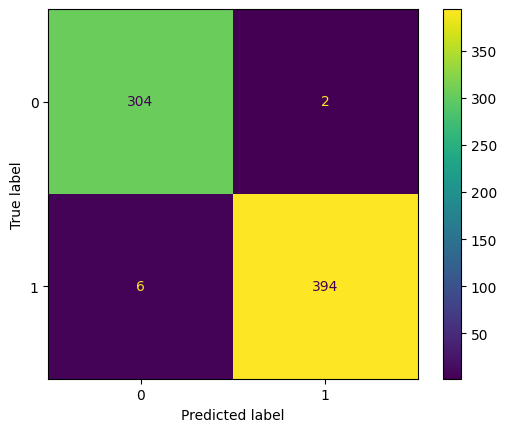

In [76]:
xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    # ('to_df', FunctionTransformer(to_df, validate=False)),
    ('xgb', XGBClassifier(
        **xgb_best_params,
        eval_metric='mlogloss',
        tree_method='hist',
        # device= 'cuda',
        objective='binary:logistic',
        random_state=42,
    ))
])

xgb_model.fit(X_train_enriched, y_train)
y_pred = xgb_model.predict(X_test_enriched)

score = f1_score(y_test, y_pred)
print(f'F1 score: {score}')
print(f'AUC ROC score: {roc_auc_score(y_test, y_pred)}')
print('Classification report:')
print(classification_report(y_test, y_pred))

print('Confusion matrix:')
cf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=xgb_model.classes_)
disp.plot(values_format='')
plt.show()

In [79]:
with open(MODEL_PATH + 'xgb_model.pkg','wb') as f:
    pickle.dump(xgb_model,f)

## LGBM

## RF

## Stack

In [38]:
def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 30, 500),
        'max_depth': trial.suggest_int('xgb_max_depth', 2, 100),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 30),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 1e-8, 0.2),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 1e-8, 2, log=True),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 1e-8, 10.0),
        'alpha': trial.suggest_float('xgb_alpha', 0.01, 15.0, log=True),
        'scale_pos_weight': trial.suggest_float('xgb_scale_pos_weight', 0.001, 5.0),
    }

    lgbm_params = {
        'metric': 'aucpr',
        'max_depth': trial.suggest_int('lgbm_max_depth', 5, 150),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 100, 1000),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.0001, 0.3, log=True),
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 5, 500),
        'subsample': trial.suggest_float('lgbm_subsample', 0.1, 0.7),
        'colsample_bytree': trial.suggest_float('lgbm_colsample_bytree', 0.4, 0.9),
        'reg_alpha': trial.suggest_float('lgbm_reg_alpha', 0.001, 3.0, log=True),
        'reg_lambda': trial.suggest_float('lgbm_reg_lambda', 1e-10, 1.0, log=True),
        'min_split_gain': trial.suggest_float('lgbm_min_split_gain', 0.3, 0.8),
    }

    rf_params = {
        'n_estimators':trial.suggest_int('rf_n_estimators', 30, 1000),
        'max_depth':trial.suggest_int('rf_max_depth', 5, 500),
        'min_samples_split':trial.suggest_int('rf_min_samples_split', 2, 300),
        'min_samples_leaf':trial.suggest_int('rf_min_samples_leaf', 1, 500),
        'max_features':trial.suggest_float('rf_max_features', 0.1, 1.0),
        'bootstrap':trial.suggest_categorical('rf_bootstrap', [True, False]),
    }

    # acc_scores = []
    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    lgbm = LGBMClassifier(
        **lgbm_params,
        verbose=-1,
        objective='binary',
        eval_metric='aucpr'
    )
    rf = RandomForestClassifier(**rf_params)
    xgb = XGBClassifier(**xgb_params)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('to_df', FunctionTransformer(to_df, validate=False)),
        ('stack', StackingClassifier(
            estimators=[('lgbm', lgbm), ('xgb', xgb), ('rf', rf)],
                        final_estimator=RandomForestClassifier(n_estimators=100)
        ))
    ])

    # for train_index, test_index in cv.split(X_train_enriched, y_train):
    #     X_train_fold, X_test_fold = X_train_enriched.iloc[train_index], X_train_enriched.iloc[test_index]
    #     y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    #     pipe.fit(X_train_fold.values, y_train_fold.values)
    #     y_pred_fold = pipe.predict(X_test_fold.values)

    #     acc = accuracy_score(y_test_fold, y_pred_fold)
    #     acc_scores.append(acc)
    #     # auc = roc_auc_score(y_test, y_pred_fold)
    pipe.fit(X_train_enriched, y_train)
    y_pred = pipe.predict(X_test_enriched)
    acc = accuracy_score(y_test, y_pred)
    # return np.mean(acc_scores)
    return acc

In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-07-10 14:22:18,468] A new study created in memory with name: no-name-7cac45ba-3d37-4b53-b254-0e5132e7f9b2
[I 2025-07-10 14:28:46,375] Trial 0 finished with value: 0.5649122807017544 and parameters: {'xgb_n_estimators': 62, 'xgb_max_depth': 20, 'xgb_min_child_weight': 29, 'xgb_learning_rate': 0.10981964447383673, 'xgb_subsample': 0.7736309629682856, 'xgb_colsample_bytree': 0.9370180511228258, 'xgb_gamma': 0.0025155805629662868, 'xgb_reg_lambda': 8.446114105358783, 'xgb_alpha': 3.431951278483411, 'xgb_scale_pos_weight': 0.3971792494809008, 'lgbm_max_depth': 134, 'lgbm_num_leaves': 564, 'lgbm_learning_rate': 0.08502386260643965, 'lgbm_n_estimators': 771, 'lgbm_min_child_samples': 343, 'lgbm_subsample': 0.6597447519073935, 'lgbm_colsample_bytree': 0.41114054783166704, 'lgbm_reg_alpha': 0.15949111532086174, 'lgbm_reg_lambda': 9.911889231927847e-06, 'lgbm_min_split_gain': 0.6473904157739321, 'rf_n_estimators': 821, 'rf_max_depth': 291, 'rf_min_samples_split': 167, 'rf_min_samples_lea

Best parameters: {'xgb_n_estimators': 265, 'xgb_max_depth': 88, 'xgb_min_child_weight': 10, 'xgb_learning_rate': 0.06520093875939305, 'xgb_subsample': 0.5527473806494948, 'xgb_colsample_bytree': 0.9269371490012352, 'xgb_gamma': 0.013871101608613861, 'xgb_reg_lambda': 2.1126041106792477, 'xgb_alpha': 0.140738361749953, 'xgb_scale_pos_weight': 2.168197404257519, 'lgbm_max_depth': 100, 'lgbm_num_leaves': 470, 'lgbm_learning_rate': 0.01787809328397837, 'lgbm_n_estimators': 484, 'lgbm_min_child_samples': 277, 'lgbm_subsample': 0.3073589431531377, 'lgbm_colsample_bytree': 0.6065511391838169, 'lgbm_reg_alpha': 0.30466819413756596, 'lgbm_reg_lambda': 0.25414257835481685, 'lgbm_min_split_gain': 0.3522589851990533, 'rf_n_estimators': 370, 'rf_max_depth': 428, 'rf_min_samples_split': 239, 'rf_min_samples_leaf': 82, 'rf_max_features': 0.10926918895734344, 'rf_bootstrap': True}


In [40]:
xgb_best_params = {
    'n_estimators': best_params['xgb_n_estimators'],
    'max_depth': best_params['xgb_max_depth'],
    'min_child_weight': best_params['xgb_min_child_weight'],
    'learning_rate': best_params['xgb_learning_rate'],
    'subsample': best_params['xgb_subsample'],
    'colsample_bytree': best_params['xgb_colsample_bytree'],
    'gamma': best_params['xgb_gamma'],
    'reg_lambda': best_params['xgb_reg_lambda'],
    'alpha': best_params['xgb_alpha'],
    'scale_pos_weight': best_params['xgb_scale_pos_weight'],
}

lgbm_best_params = {
    'metric': 'aucpr',
    'max_depth': best_params['lgbm_max_depth'],
    'num_leaves': best_params['lgbm_num_leaves'],
    'learning_rate': best_params['lgbm_learning_rate'],
    'n_estimators': best_params['lgbm_n_estimators'],
    'min_child_samples': best_params['lgbm_min_child_samples'],
    'subsample': best_params['lgbm_subsample'],
    'colsample_bytree': best_params['lgbm_colsample_bytree'],
    'reg_alpha': best_params['lgbm_reg_alpha'],
    'reg_lambda': best_params['lgbm_reg_lambda'],
    'min_split_gain': best_params['lgbm_min_split_gain'],
}

rf_best_params = {
    'n_estimators':best_params['rf_n_estimators'],
    'max_depth':best_params['rf_max_depth'],
    'min_samples_split':best_params['rf_min_samples_split'],
    'min_samples_leaf':best_params['rf_min_samples_leaf'],
    'max_features':best_params['rf_max_features'],
    'bootstrap':best_params['rf_bootstrap'],
}

lgbm = LGBMClassifier(
    **lgbm_best_params,
    verbose=-1,
    objective='binary',
    eval_metric='aucpr'
)
rf = RandomForestClassifier(**rf_best_params)
xgb = XGBClassifier(**xgb_best_params)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('to_df', FunctionTransformer(to_df, validate=False)),
    ('stack', StackingClassifier(
        estimators=[('lgbm', lgbm), ('xgb', xgb), ('rf', rf)],
                    final_estimator=RandomForestClassifier(n_estimators=100)
    ))
])

model.fit(X_train_enriched, y_train)

,steps,"[('scaler', ...), ('to_df', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,func,<function to_...t 0x126d9b920>
,inverse_func,None
,validate,False
,accept_sparse,False


In [41]:
predictions = model.predict(X_test_enriched)

## Model evaluation

F1 score: 0.6565349544072948
AUC ROC score: 0.5942158616577221
Classification report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       129
           1       0.62      0.69      0.66       156

    accuracy                           0.60       285
   macro avg       0.60      0.59      0.59       285
weighted avg       0.60      0.60      0.60       285

Confusion matrix:


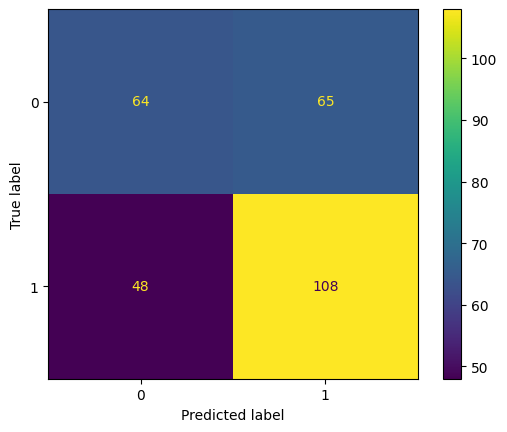

In [42]:
score = f1_score(y_test, predictions)
print(f'F1 score: {score}')
print(f'AUC ROC score: {roc_auc_score(y_test, predictions)}')
print('Classification report:')
print(classification_report(y_test, predictions))

print('Confusion matrix:')
cf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=model.classes_)
disp.plot(values_format='')
plt.show()